# ~ ~ ~ Spectral Diagnostics using FISS data ~ ~ ~ 

#### In this notebook

Describe what we do here!

In [3]:
# We will import some basic packages:

from astropy.io import fits
import numpy as np 
import matplotlib.pyplot as plt 

In [4]:
# First we will open the most dramatic spectral line, H alpha
cube_halpha = fits.open("Halpha.FISS.20170614_170511.quiet.fits")[0].data
cube_halpha.shape

(150, 256, 512)

In [3]:
# We have 512 wavelenght points, at 150 x 256 pixels! (Each pixel is 0.16 arcsec, so something like ~ 100 km)

Text(0.5, 1.0, 'Continuum')

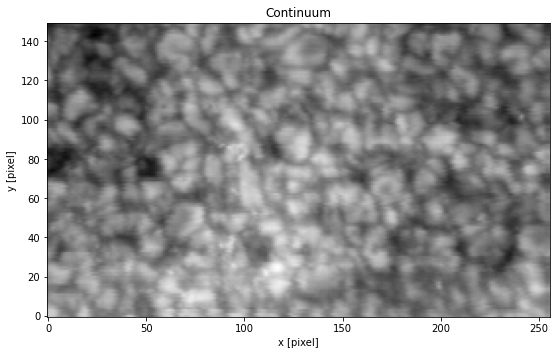

In [11]:
# Let's plot one wavelength to see if this makes sense. Image is basically spatial distribution of 
# the intensity at a fixed wavelength:
plt.figure(figsize=[9,9])
plt.imshow(cube_halpha[:,:,0],cmap='gray',origin='lower')
plt.xlabel("x [pixel]")
plt.ylabel("y [pixel]")
plt.title("Continuum")

Now, we will calculate to spatially averaged spectrum to see what are we dealing with here. It is good to see how our spectral line looks like. To plot that in  meaningful way we will also need wavelengths. They are in the same file:

In [8]:
ll_halpha = fits.open("wavha.fiss.20170614.fits")[0].data
ll_halpha.shape

(512,)

512 wavelengthts for 512 wavelength points, looks good so far!

In [68]:
# Let's normalize the cube as we say
cube_halpha /= np.mean(cube_halpha[:,:,0]) 

In [69]:
mean_spectrum = np.mean(cube_halpha,axis=(0,1))

Text(0.5, 1.0, 'Spatially averaged spectrum')

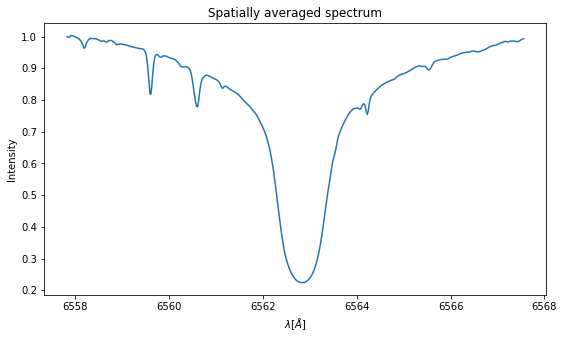

In [70]:
plt.figure(figsize=[9,5])
plt.plot(ll_halpha,mean_spectrum)
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("Intensity")
plt.title("Spatially averaged spectrum")

Looks like H$\alpha$ indeed! Discuss a little bit the line shape here. Also the wing extension (or lack thereof)

#### Now, in the next chapter we will find the center of the line as the minimum of the mean spectrum. We will do that by fitting a parabola through 5 points around the perceived center of the line (the point if with minimum intensity). Note that this is more precise than just picking the wavelength with minimum intensity. 

### Now, let's scan through the line. To make it easier, first plot the spectrum with indices as x-axis to see easier which index belongs to continuum, wing, linecore, etc...

Text(0.5, 1.0, 'Spatially averaged spectrum')

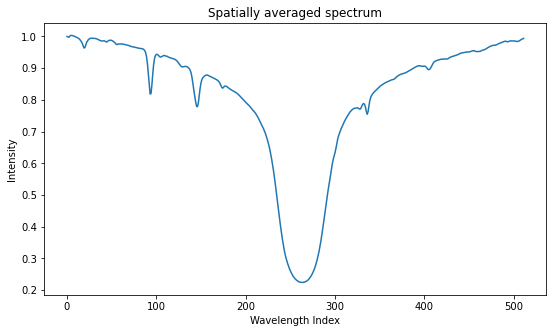

In [71]:
plt.figure(figsize=[9,5])
plt.plot(mean_spectrum)
plt.xlabel("Wavelength Index")
plt.ylabel("Intensity")
plt.title("Spatially averaged spectrum")

Text(0.5, 1.0, 'Wavelength of your choice')

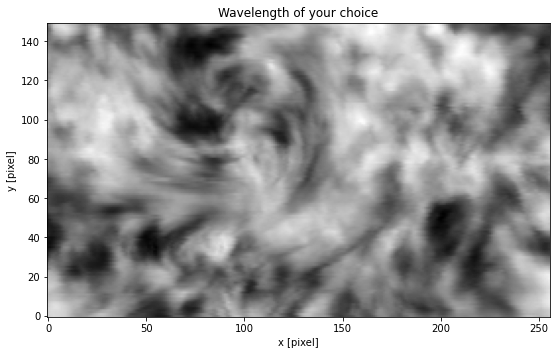

In [72]:
# Let's plot the image, wavelength by wavelength. Choose interesting indices from the plot above:
plt.figure(figsize=[9,9])
plt.imshow(cube_halpha[:,:,240],cmap='gray',origin='lower')
plt.xlabel("x [pixel]")
plt.ylabel("y [pixel]")
plt.title("Wavelength of your choice")

In [75]:
indmin = np.argmin(mean_spectrum) #Index of the point with minimum intensity:
print (indmin) # test if that makes sense

# We will subtract the percieved mean wavelength. This is to improve numerical stability of the fit
x = ll_halpha[indmin-10:indmin+11]-np.mean(ll_halpha[indmin-10:indmin+11]) 
y = mean_spectrum[indmin-10:indmin+11]

# Fit a parabola (polynomial of degree 2, through a couple of points each side of( center)
p = np.polyfit(x,y,2)
print (p)
# Location of the minimum is -b/2a where y = ax^2 + bx + c
ll0 = -p[1]/2/p[0] + np.mean(ll_halpha[indmin-10:indmin+11])
print (ll0)

263
[ 0.54428238 -0.00246012  0.22384024]
6562.836244340889


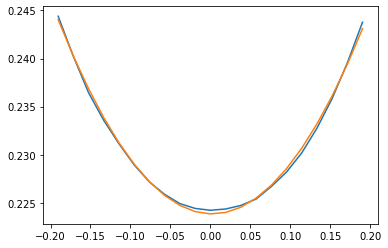

In [76]:
# If you want to be sure the fit is good, have a look here:

fit = x**2.0 * p[0] + x * p[1] + p[2]
plt.plot(x,y)
plt.plot(x,fit)

We all know by hard magical numbers of Halpha line center 6562.8, and this is very close to it. (Probably someone already calibrated the data). It did not have to be, and it is always good to re-center your observations to what you think is the rest wavelength. 

#### To summarize, let's plot a 4-panel with image of the solar surface at few different wavelengths:

Text(0.5, 1.0, 'Wavelength = -0.0022599658886974794')

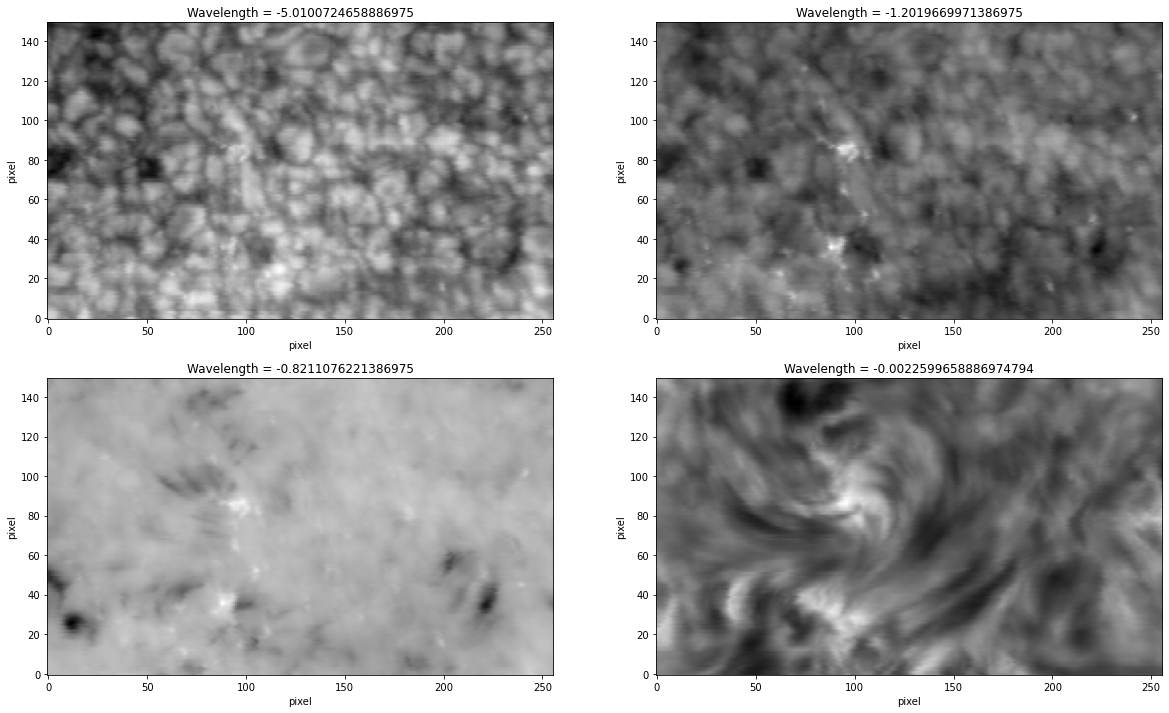

In [125]:
# Let's plot one wavelength to see if this makes sense
indices = [0,200,220,263]

plt.figure(figsize=[20,12])
plt.subplot(221)
plt.imshow(cube_halpha[:,:,indices[0]],cmap='gray',origin='lower')
plt.xlabel("pixel")
plt.ylabel("pixel")
plt.title("Wavelength = "+str(ll_halpha[indices[0]]-ll0))
plt.subplot(222)
plt.imshow(cube_halpha[:,:,indices[1]],cmap='gray',origin='lower')
plt.xlabel("pixel")
plt.ylabel("pixel")
plt.title("Wavelength = "+str(ll_halpha[indices[1]]-ll0))
plt.subplot(223)
plt.imshow(cube_halpha[:,:,indices[2]],cmap='gray',origin='lower')
plt.xlabel("pixel")
plt.ylabel("pixel")
plt.title("Wavelength = "+str(ll_halpha[indices[2]]-ll0))
plt.subplot(224)
plt.imshow(cube_halpha[:,:,indices[3]],cmap='gray',origin='lower')
plt.xlabel("pixel")
plt.ylabel("pixel")
plt.title("Wavelength = "+str(ll_halpha[indices[3]]-ll0))

Now, another way of thinking about this multi-wavelength images is to say we got a spectrum for each pixel. If you don't trust us, let's have a look at that, we have 150 x 256 pixels, so let's pick some random indices and plot these spectra

In [78]:
sample_x = np.random.choice(149,10)
sample_y = np.random.choice(255,10)
print (sample_x, sample_y)

[107 138  98 134  57 148 116   6  23  53] [132  42 174 230 233  50 252  23 141 219]


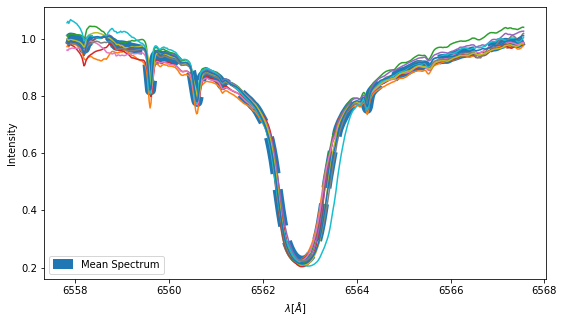

In [79]:
plt.figure(figsize=[9,5])
plt.plot(ll_halpha,mean_spectrum,'--',linewidth=10,label='Mean Spectrum')
plt.xlabel("$\\lambda [\\AA]$")
plt.ylabel("Intensity")
for i in range(0,10):
    plt.plot(ll_halpha,cube_halpha[sample_x[i],sample_y[i],:])
plt.legend()

### Why are the spectra different? And why are they not THAT different.
#### Think about the following: 
- Line center position
- Line asymmetry 
- "Continuum" level
- Line core level
- Line width

## Finding velocities as the line center position shift

If you look at the above, you will see that he positions of the line centers (minima) are slightly different for each pixel. If we say that is is some representative velocity "seen" by H$\alpha$ line, we can use this to infer velocity via Doppler effect. 

#### What are some conceptual problems with this? 

.

.

.
#### Even with all these, we will get some idea of the velocity. Let's use the concept from the above (fitting the parabola around the line core), to infer velocities for each pixel. 

In [80]:
def calc_line_center(spectrum, wavelength):
    indmin = np.argmin(spectrum) #Index of the point with minimum intensity:
    
    x = (wavelength - np.mean(wavelength))[indmin-5:indmin+6]
    y = spectrum[indmin-5:indmin+6]
    # Fit a parabola (polynomial of degree 2, through a couple of points each side of center)
    p = np.polyfit(x,y,2)
    
    l_center = -p[1]/2/p[0] + np.mean(wavelength)
    return l_center

In [81]:
# Let's try on a random spectrum and see if it makes sense: 
l_center_random = calc_line_center(cube_halpha[7,6],ll_halpha)
print (l_center_random)

6562.946751966858


In [82]:
# Looks reasonable, what velocity would this be? 
c = 2.997E5 # in km/s
v_test = (l_center_random-ll0)/ll0 *c 
print (v_test)

5.046466842976978


Nice velocity! Proper way to do this would be to use it on the whole map, so that we can plot velocity maps. 

In [42]:
line_centers = np.zeros([150,256])
for i in range(0,150):
    for j in range(0,256):
        line_centers[i,j] = calc_line_center(cube_halpha[i,j],ll_halpha)

In [43]:
v_line_center = (line_centers - ll0)/ll0 * c

Text(0, 0.5, 'y [pix]')

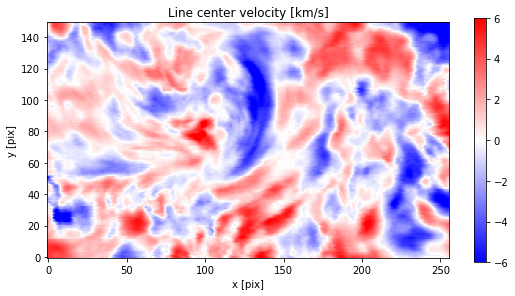

In [54]:
# And let's plot the velocity map! Exciting!
plt.figure(figsize=[9,9])
plt.imshow(v_line_center,vmin=-6,vmax=6,cmap='bwr',origin='lower')
plt.colorbar(shrink=0.5)
plt.title("Line center velocity [km/s]")
plt.xlabel("x [pix]")
plt.ylabel("y [pix]")

### Let's plot these velocities side-by-side with the line core to see how the two correlate:

Text(0, 0.5, 'y [pix]')

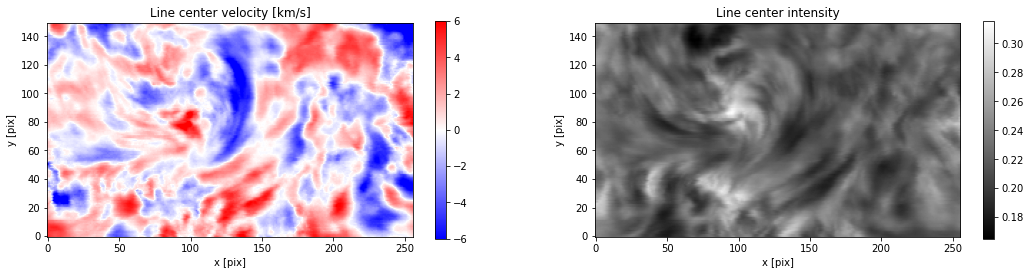

In [127]:
# And let's plot the velocity map! Exciting!
plt.figure(figsize=[18,8])
plt.subplot(121)
plt.imshow(v_line_center,vmin=-6,vmax=6,cmap='bwr',origin='lower')
plt.colorbar(shrink=0.5)
plt.title("Line center velocity [km/s]")
plt.xlabel("x [pix]")
plt.ylabel("y [pix]")
plt.subplot(122)
plt.imshow(cube_halpha[:,:,indices[3]],cmap='gray',origin='lower')
plt.colorbar(shrink=0.5)
plt.title("Line center intensity")
plt.xlabel("x [pix]")
plt.ylabel("y [pix]")

### Let's spend some time discussing this. What do these velocities mean? What do they tell us? What are the advantages and disadvantages of this approach?

After we are done with these, we can play and visualize a little bit this, but we can also move toward a more sophisticated method:

## Finding velocity via bisectors!!!!

In [109]:
# Let's go toward the hardest mode first! Bisectors!
levels = np.asarray([0.85,0.7,0.6,0.5,0.4])

In [110]:
def calc_bisectors(spectrum,wavelength,levels):
    # this is the function that takes in the spectrum, wavelength and desired bisector levels
    # and returns the position of the center of the horizontal line that connects the points 
    # of the desired from both sides of the >>local<< line center (meanining the point with min intensity)
    from scipy.interpolate import interp1d
    
    local_min = np.argmin(spectrum)
    
    result = np.zeros(len(levels))
    
    for i in range(0,len(levels)):
        f = interp1d(spectrum[:local_min],wavelength[:local_min])
        left_position = f(levels[i])
        f = interp1d(spectrum[local_min:],wavelength[local_min:])
        right_position = f(levels[i])
        result[i] = (right_position + left_position)*0.5
        
    return result

In [111]:

test = calc_bisectors(cube_halpha[6,7]/mean_spectrum[0],ll_halpha,levels) 

In [112]:
print (test)

[6562.87628532 6562.85439704 6562.86422462 6562.8672847  6562.87461451]


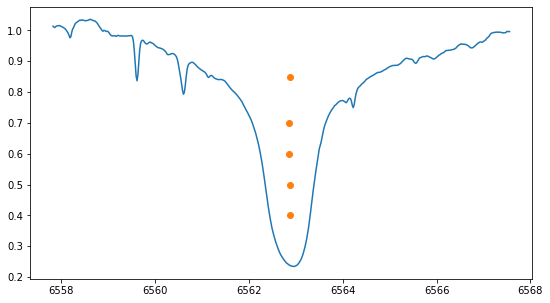

In [113]:
plt.figure(figsize=[9,5])
plt.plot(ll_halpha,cube_halpha[6,7])
plt.plot(test,levels,'o')

In [114]:
# Translate bisectors to velocities:
bisector_velocities = (test-ll0)/ll0 * 2.997E5

In [115]:
print (bisector_velocities)
print (ll0)

[1.82852072 0.82896553 1.27775411 1.41749623 1.75222083]
6562.836244340889


In [116]:
bisectors = np.zeros([150,256,5])
for i in range(0,150):
    for j in range(0,256):
        bisectors[i,j,:] = calc_bisectors(cube_halpha[i,j,:],ll_halpha,levels)

In [117]:
bisector_velocities = (bisectors-ll0)/ll0 * 2.997E5

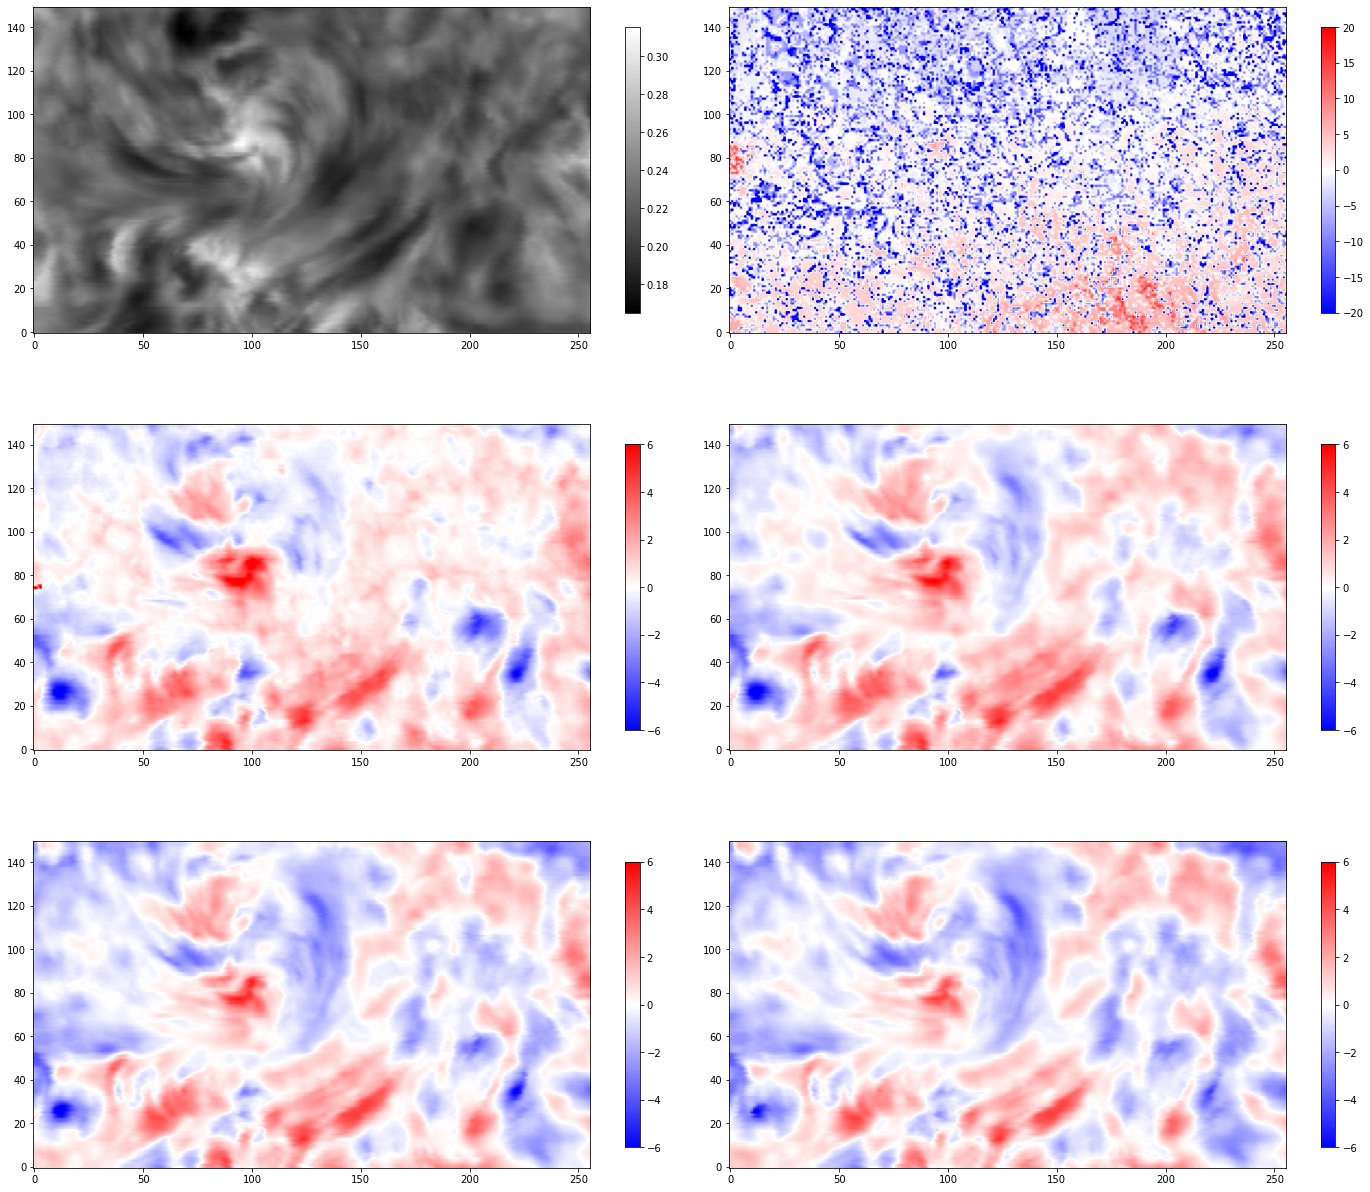

In [129]:
plt.figure(figsize=[20,18])
plt.subplot(321)
plt.imshow(cube_halpha[:,:,263],cmap='gray',origin='lower')
plt.colorbar(shrink=0.65)
plt.subplot(322)
plt.imshow(bisector_velocities[:,:,0],cmap='bwr',vmin=-20,vmax=20,origin='lower')
plt.colorbar(shrink=0.65)
plt.subplot(323)
plt.imshow(bisector_velocities[:,:,1],cmap='bwr',vmin=-6,vmax=6,origin='lower')
plt.colorbar(shrink=0.65)
plt.subplot(324)
plt.imshow(bisector_velocities[:,:,2],cmap='bwr',vmin=-6,vmax=6,origin='lower')
plt.colorbar(shrink=0.65)
plt.subplot(325)
plt.imshow(bisector_velocities[:,:,3],cmap='bwr',vmin=-6,vmax=6,origin='lower')
plt.colorbar(shrink=0.65)
plt.subplot(326)
plt.imshow(bisector_velocities[:,:,4],cmap='bwr',vmin=-6,vmax=6,origin='lower')
plt.colorbar(shrink=0.65)
plt.tight_layout()

### Let's try to investigate the behaviour of specific pixels. Namely, we want to investigate the dark features seen in the line wing (say. 0.8 Angstroms from the line core). That corresponds to our wavelength index 220

In [156]:
%matplotlib notebook
import matplotlib.pyplot as plt 


<IPython.core.display.Javascript object>


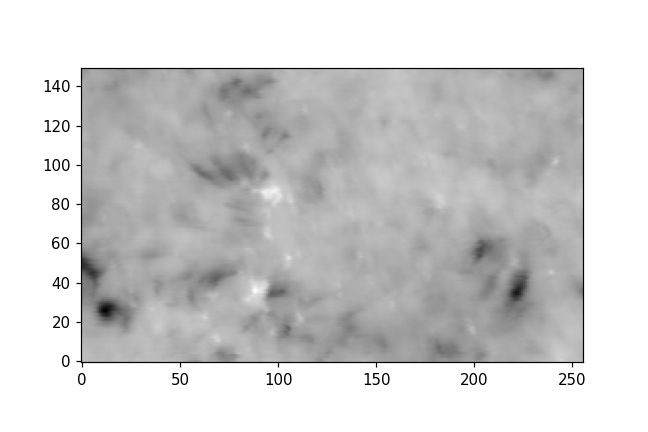

9

In [157]:
# Let's plot the image, wavelength by wavelength. Choose interesting indices from the plot above:
f,a = plt.subplots()
pos = []
def onclick(event):
    pos.append([event.xdata,event.ydata])
a.imshow(cube_halpha[:,:,220],cmap='gray',origin='lower')
f.canvas.mpl_connect('button_press_event', onclick)

In [149]:
print(pos)

[[61.23635612679211, 93.24058533079449], [69.6473477635902, 97.82839895086619], [75.76443259035244, 98.59303455421147], [103.29131431078255, 113.1211110177718]]


In [158]:
%matplotlib inline
import matplotlib.pyplot as plt 
# This is reverting back to the default plotting style

### To finish this, let's calculate the width of the line! 

In [167]:
# We are going to it like this: 
def width(spectrum,wavelength):
    # The idea is to take the local line center, then two points 1A to each side. 
    # Calculate the mean of these two, half that and calculate the width at that level
    # (as if you were calculating the bisector). Let's go
    from scipy.interpolate import interp1d
    
    line_core = calc_line_center(spectrum,wavelength)
    l_left = line_core - 1.0
    l_right = line_core + 1.0
    
    f = interp1d(wavelength,spectrum)
    I_left = f(l_left)
    I_right = f(l_right)
    I_mean = 0.5*(I_left+I_right)
    I_min = f(line_core)
    I_crit = I_min + (I_mean - I_min)*0.5
    
    # Now we need to find points at this level at each side of the core: 
    # Point closest to the line center:
    local_min = np.argmin(np.abs(wavelength-line_core))
    
    f = interp1d(spectrum[:local_min],wavelength[:local_min])
    left_position = f(I_crit)
    f = interp1d(spectrum[local_min:],wavelength[local_min:])
    right_position = f(I_crit)
    result = (right_position - left_position)
        
    return result

In [168]:
print (width(cube_halpha[6,7],ll_halpha))

1.0313423922561924


In [169]:
# Let calculate for the whole map:
widths = np.zeros([150,256])
for i in range(0,150):
    for j in range(0,256):
        widths[i,j] = width(cube_halpha[i,j,:],ll_halpha)

Text(0, 0.5, 'y [pix]')

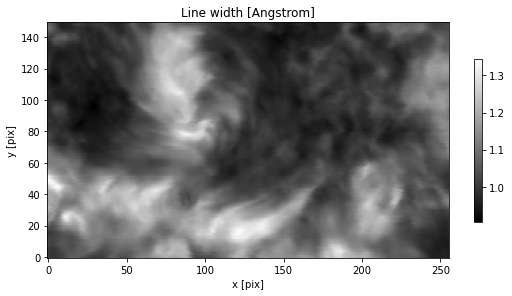

In [171]:
# And let's plot the velocity map! Exciting!
plt.figure(figsize=[9,6])
plt.imshow(widths,cmap='gray',origin='lower')
plt.colorbar(shrink=0.5)
plt.title("Line width [Angstrom]")
plt.xlabel("x [pix]")
plt.ylabel("y [pix]")

Text(0, 0.5, 'y [pix]')

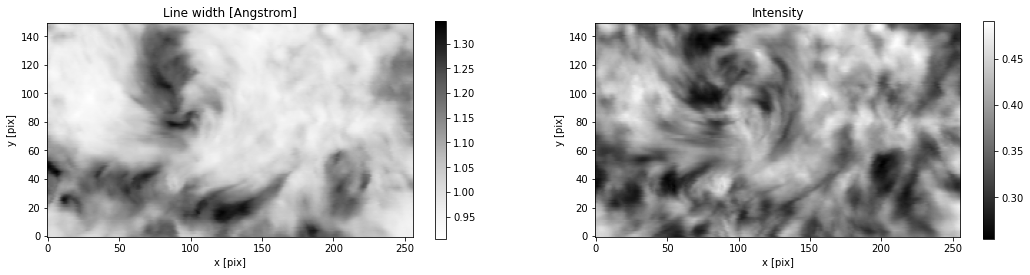

In [178]:
plt.figure(figsize=[18,8])
plt.subplot(121)
plt.imshow(widths,cmap='Greys',origin='lower')
plt.colorbar(shrink=0.5)
plt.title("Line width [Angstrom]")
plt.xlabel("x [pix]")
plt.ylabel("y [pix]")
plt.subplot(122)
plt.imshow(cube_halpha[:,:,240],cmap='gray',origin='lower')
plt.colorbar(shrink=0.5)
plt.title("Intensity")
plt.xlabel("x [pix]")
plt.ylabel("y [pix]")